In [1]:
!pip install lifelines

# ============================================
# - CSV 로드 → 전처리/학습 → 평가 → 중요도 → 단건 예측 → 저장
# ============================================

# 0) 라이브러리

In [35]:
import warnings, sys, json, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import joblib

print("Python:", sys.version.split()[0], "| scikit-learn:", sklearn.__version__)

Python: 3.10.18 | scikit-learn: 1.4.2


# 1) 데이터 로드

In [37]:
CSV_PATH = "WA_Fn-UseC_-HR-Employee-Attrition.csv"

def read_csv_smart(path):
    for enc in ("utf-8", "cp949", "euc-kr"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(path)  # 마지막 시도

df = read_csv_smart(CSV_PATH)
print(f"CSV 로드 완료: shape={df.shape}")
print("컬럼 샘플:", list(df.columns)[:10])
display(df.head(5))

CSV 로드 완료: shape=(1470, 29)
컬럼 샘플: ['나이', '회사와의마찰', '출장', '일당', '부서', '거리', '학력', '전공', '사번', '만족도']


,나이,회사와의마찰,출장,일당,부서,거리,학력,전공,사번,만족도,...,성인여부,야근,업무평가,주변평가,근무기준시간,스톡옵션레벨,경력,전년도교육출장횟수,워라밸,현회사근속년수
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,Y,Yes,3,1,80,0,8,0,1,6
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,Y,No,4,4,80,1,10,3,3,10
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,Y,Yes,3,2,80,0,7,3,3,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,Y,Yes,3,3,80,0,8,3,3,8
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,Y,No,3,4,80,1,6,3,3,2


# 2) 타깃/피처 설정 + 불필요 컬럼 제거

In [38]:
target = "업무평가"  # 한글 타깃
assert target in df.columns, f"타깃 '{target}'이 존재하지 않습니다. 컬럼: {list(df.columns)}"

drop_if_present = ["사번", "성인여부", "근무기준시간"]  # 상수/ID/의미없는 것 제거
cols_to_drop = [c for c in drop_if_present if c in df.columns]

X = df.drop(columns=[target] + cols_to_drop)
y = df[target]

print("제거한 컬럼:", cols_to_drop)
print("X shape:", X.shape)
print("y 분포 (상위):\n", y.value_counts().head())

# 3) 숫자/범주형 구분 (반드시 X 기준)
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
print("숫자형:", len(num_cols), "| 범주형:", len(cat_cols))

제거한 컬럼: ['사번', '성인여부', '근무기준시간']
X shape: (1470, 25)
y 분포 (상위):
 업무평가
3    1244
4     226
Name: count, dtype: int64
숫자형: 17 | 범주형: 8


# 4) 전처리 + 모델 (OHE 버전-안전)

In [39]:
try:
    # sklearn 1.2+ 권장 인자
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    # 구버전 호환 (<=1.1)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(transformers=[
    ("num", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ]), cat_cols)
])

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])

# 5) 학습/검증 분리 (분류는 stratify 권장, 실패 시 해제)

In [40]:
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

# 6) 학습

In [41]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['나이', '일당', '거리', '학력',
                                                   '만족도', '시급', '참여프로젝트',
                                                   '근속연차', '직업만족도', '월급',
                                                   '이직회수', '주변평가', '스톡옵션레벨',
                                                   '경력', '전년도교육출장횟수', '워라밸',
                                                   '현회사근속년수']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['회사와의마찰', '출장', '부서', '전공',
                                                   '성별', '직급', '결혼여부',
                                                   '야근'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

# 7) 평가

Accuracy: 0.8469
F1 (weighted): 0.7768

[Classification Report]
               precision    recall  f1-score   support

           3       0.85      1.00      0.92       249
           4       0.00      0.00      0.00        45

    accuracy                           0.85       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.72      0.85      0.78       294



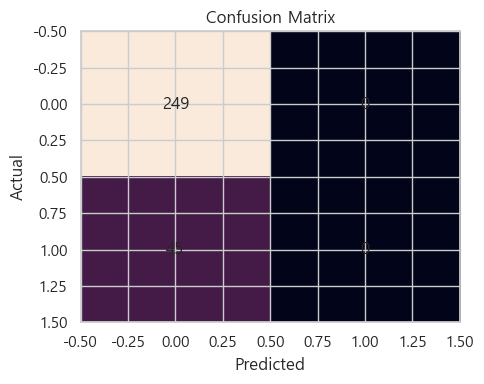

In [42]:
y_pred = pipe.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 (weighted):", round(f1_score(y_test, y_pred, average="weighted"), 4))
print("\n[Classification Report]\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, aspect="auto")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# 8) 한글 폰트 설정 (그래프 깨짐 방지)

In [43]:
from matplotlib import font_manager, rcParams
candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "DejaVu Sans"]
available = {f.name for f in font_manager.fontManager.ttflist}
for f in candidates:
    if f in available:
        rcParams["font.family"] = f
        rcParams["axes.unicode_minus"] = False
        break
print("그래프 폰트:", rcParams.get("font.family"))

그래프 폰트: ['Malgun Gothic']


# 9) Permutation Importance (스코어 3종 비교, 반복↑로 가독성↑)


[Permutation Importance: accuracy]


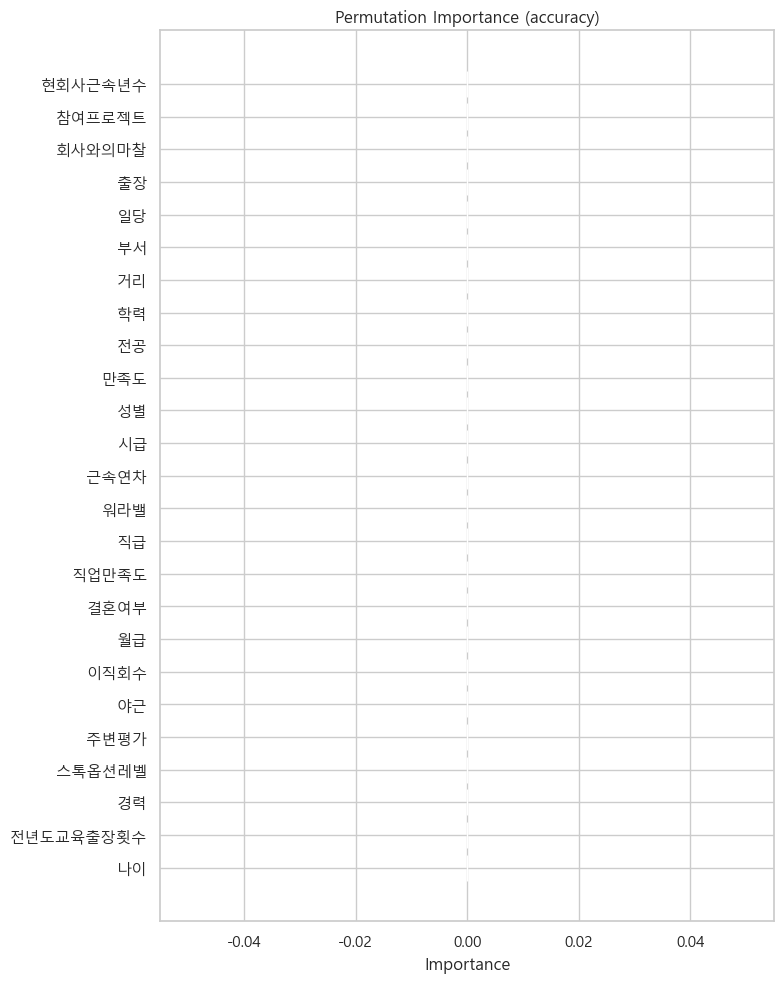

TOP 10: [('현회사근속년수', 0.0), ('참여프로젝트', 0.0), ('회사와의마찰', 0.0), ('출장', 0.0), ('일당', 0.0), ('부서', 0.0), ('거리', 0.0), ('학력', 0.0), ('전공', 0.0), ('만족도', 0.0)]

[Permutation Importance: f1_macro]


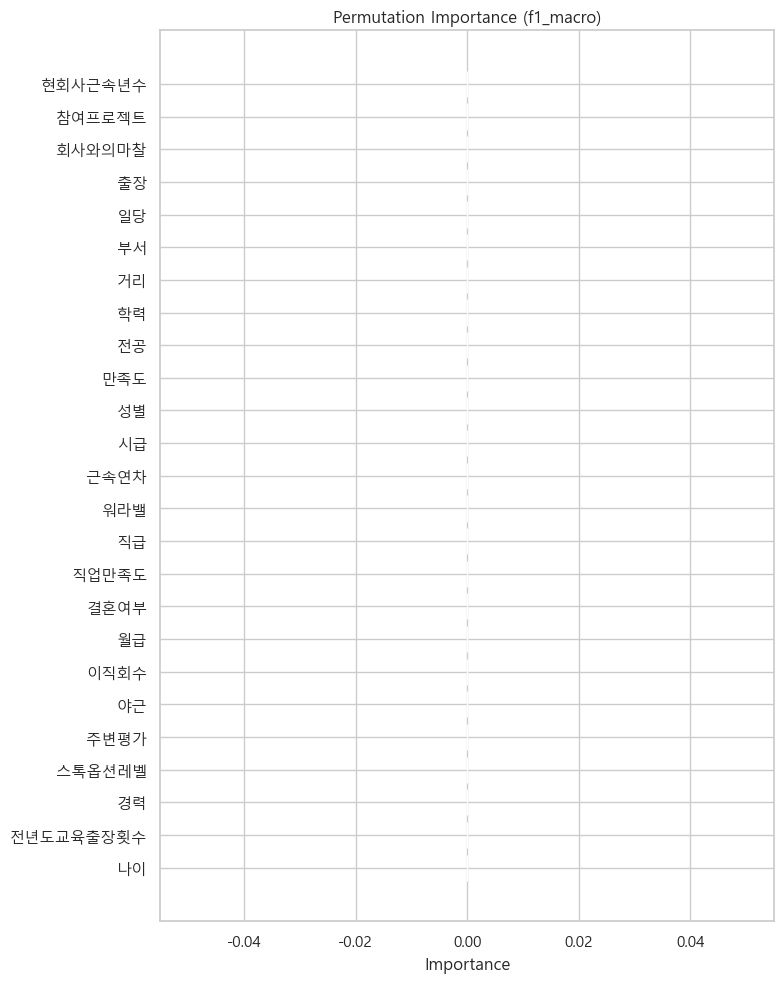

TOP 10: [('현회사근속년수', 0.0), ('참여프로젝트', 0.0), ('회사와의마찰', 0.0), ('출장', 0.0), ('일당', 0.0), ('부서', 0.0), ('거리', 0.0), ('학력', 0.0), ('전공', 0.0), ('만족도', 0.0)]

[Permutation Importance: f1_weighted]


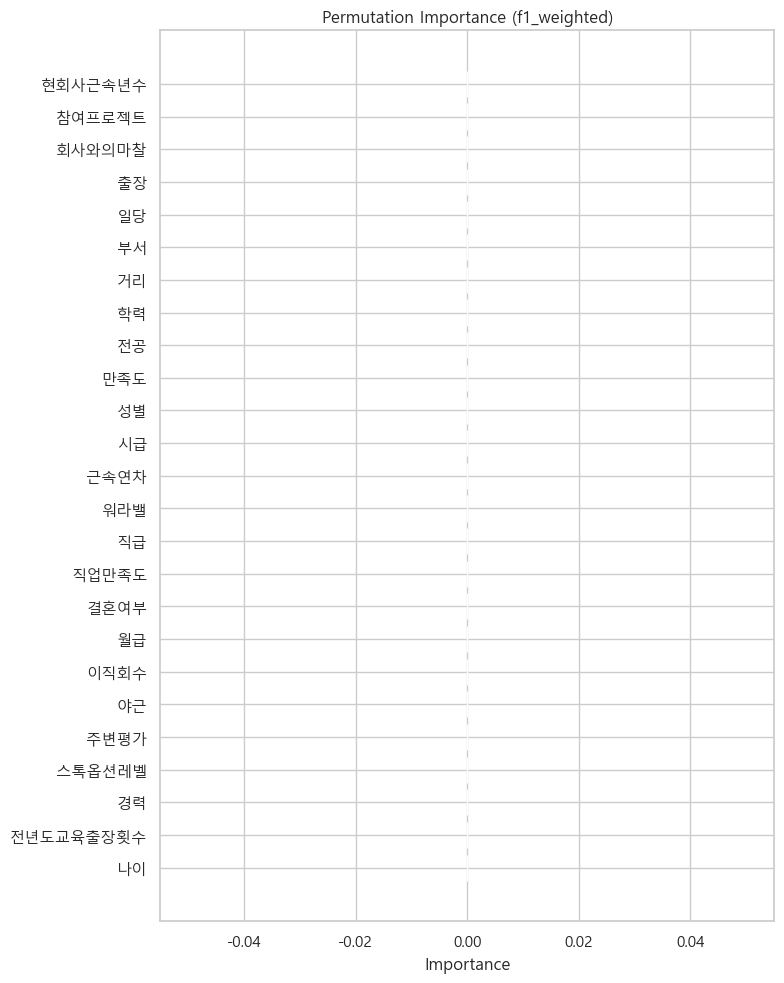

TOP 10: [('현회사근속년수', 0.0), ('참여프로젝트', 0.0), ('회사와의마찰', 0.0), ('출장', 0.0), ('일당', 0.0), ('부서', 0.0), ('거리', 0.0), ('학력', 0.0), ('전공', 0.0), ('만족도', 0.0)]


In [44]:
def plot_perm(scoring="accuracy", n_repeats=30):
    r = permutation_importance(
        pipe, X_test, y_test,
        n_repeats=n_repeats, random_state=42, n_jobs=-1, scoring=scoring
    )
    imp, std = r.importances_mean, r.importances_std
    idx = np.argsort(imp)[::-1]

    plt.figure(figsize=(8, max(4, int(len(idx)*0.4))))
    plt.barh(range(len(idx)), imp[idx], xerr=std[idx])
    plt.yticks(range(len(idx)), [X.columns[i] for i in idx])
    plt.gca().invert_yaxis()
    plt.title(f"Permutation Importance ({scoring})")
    plt.xlabel("Importance"); plt.tight_layout(); plt.show()
    print("TOP 10:", [(X.columns[i], round(imp[i], 4)) for i in idx[:10]])

print("\n[Permutation Importance: accuracy]")
plot_perm("accuracy", n_repeats=30)

print("\n[Permutation Importance: f1_macro]")
plot_perm("f1_macro", n_repeats=30)

print("\n[Permutation Importance: f1_weighted]")
plot_perm("f1_weighted", n_repeats=30)

# 10) 사용자 입력 예측 (템플릿 자동 생성 → 값만 수정)

In [45]:
template = {}
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        template[c] = float(X[c].median())
    else:
        template[c] = X[c].mode().iloc[0]

print("\n[예측 템플릿 예시] 일부만 표시:", dict(list(template.items())[:8]))

# 예시: 실제 데이터에 존재하는 카테고리 값으로 수정해 사용하세요
user_input = dict(template)
# user_input.update({
#     "나이": 34,
#     "출장": "자주",
#     "일당": 250,
#     "부서": "영업",
#     "야근": "예",
#     "참여프로젝트": 5,
#     "주변평가": 4
# })
# pred = pipe.predict(pd.DataFrame([user_input]))[0]
# print("예측된 업무평가:", pred)


[예측 템플릿 예시] 일부만 표시: {'나이': 36.0, '회사와의마찰': 'No', '출장': 'Travel_Rarely', '일당': 802.0, '부서': 'Research & Development', '거리': 7.0, '학력': 3.0, '전공': 'Life Sciences'}


# 11) 교차검증

In [46]:
try:
    cv = cross_val_score(pipe, X, y, cv=5, scoring="f1_weighted", n_jobs=-1)
    print(f"\n5-Fold CV (F1_weighted): mean={cv.mean():.4f} ± {cv.std():.4f}")
except Exception as e:
    print("CV 스킵:", e)


5-Fold CV (F1_weighted): mean=0.7758 ± 0.0019


# 12) 모델 저장/불러오기

In [47]:
MODEL_PATH = "업무평가_모델.joblib"
joblib.dump(pipe, MODEL_PATH)
print("모델 저장:", MODEL_PATH)
loaded = joblib.load(MODEL_PATH)
print("불러오기 OK:", isinstance(loaded, Pipeline))

모델 저장: 업무평가_모델.joblib
불러오기 OK: True
